In [1]:
!pip install scFates

In [2]:
import sys
!{sys.executable} -m pip -q install palantir fa2

In [3]:
import warnings
warnings.filterwarnings("ignore")
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import palantir
import matplotlib.pyplot as plt
sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout
## fix palantir breaking down some plots
import seaborn
seaborn.reset_orig()
%matplotlib inline

sc.set_figure_params()
scf.set_figure_pubready()

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [110]:
adata = sc.read_10x_mtx(r"/mnt/c/Users/Emil/10X/scretina/D59_fetal_filtered_gene_bc_matrices/GRCh38/", cache = True)

... reading from cache file cache/mnt-c-Users-Emil-10X-scretina-D59_fetal_filtered_gene_bc_matrices-GRCh38-matrix.h5ad


In [24]:
adata2 = sc.read_10x_mtx(r"/mnt/c/Users/Emil/10X/scretina/D125Pfetal_filtered_gene_bc_matrices/GRCh38/", cache = True)


... reading from cache file cache/mnt-c-Users-Emil-10X-scretina-D125Pfetal_filtered_gene_bc_matrices-GRCh38-matrix.h5ad


In [25]:
adata1 = sc.read_10x_mtx(r"/mnt/c/Users/Emil/10X/scretina/D125Cfetal_filtered_gene_bc_matrices/GRCh38/", cache = True)

... reading from cache file cache/mnt-c-Users-Emil-10X-scretina-D125Cfetal_filtered_gene_bc_matrices-GRCh38-matrix.h5ad


In [27]:
adata3 = sc.read_10x_mtx(r"/mnt/c/Users/Emil/10X/scretina/D82Cfetal_filtered_gene_bc_matrices/GRCh38/", cache = True)

... writing an h5ad cache file to speedup reading next time


In [28]:
adata4 = sc.read_10x_mtx(r"/mnt/c/Users/Emil/10X/scretina/D82Pfetal_filtered_gene_bc_matrices/GRCh38/", cache = True)

... writing an h5ad cache file to speedup reading next time


In [111]:
adata.obs['stage'] = 'FD59'

In [112]:
adata1.obs['stage'] = 'FD125'
adata2.obs['stage'] = 'FD125'
adata3.obs['stage'] = 'FD82'
adata4.obs['stage'] = 'FD82'

In [118]:
adataall.obs

stage batch
AAACATACGAGGCA-1-0  FD59     0
AAACATACTTCCAT-1-0  FD59     0
AAACATACTTTCAC-1-0  FD59     0
AAACATTGACCTGA-1-0  FD59     0
AAACCGTGAGAACA-1-0  FD59     0
...                  ...   ...
TTTAGGCTTGCCTC-1-4  FD82     4
TTTAGGCTTTGACG-1-4  FD82     4
TTTATCCTTGCTCC-1-4  FD82     4
TTTCAGTGGCTTAG-1-4  FD82     4
TTTGCATGCACAAC-1-4  FD82     4

[50406 rows x 2 columns]

In [115]:
adata.obs_names_make_unique()

In [116]:
adata1.obs_names_make_unique()
adata2.obs_names_make_unique()
adata3.obs_names_make_unique()
adata4.obs_names_make_unique()

In [117]:
adataall = AnnData.concatenate(adata, adata1, adata2, adata3, adata4)

In [109]:
adataall.obs

stage batch
AAACATACGAGGCA-1-0  FD59     0
AAACATACTTCCAT-1-0  FD59     0
AAACATACTTTCAC-1-0  FD59     0
AAACATTGACCTGA-1-0  FD59     0
AAACCGTGAGAACA-1-0  FD59     0
...                  ...   ...
TTTAGGCTTGCCTC-1-4  FD82     4
TTTAGGCTTTGACG-1-4  FD82     4
TTTATCCTTGCTCC-1-4  FD82     4
TTTCAGTGGCTTAG-1-4  FD82     4
TTTGCATGCACAAC-1-4  FD82     4

[50406 rows x 2 columns]

In [119]:
adata = adataall

In [120]:
sc.pp.filter_genes(adata,min_cells=1)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata,base=10)
sc.pp.highly_variable_genes(adata)

filtered out 9430 genes that are detected in less than 1 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [121]:
sc.pp.highly_variable_genes(adata, n_top_genes=1500, flavor='cell_ranger')
sc.pp.pca(adata)
pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


In [122]:
pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)

In [123]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)


In [124]:
# generate neighbor draph in multiscale diffusion space
adata.obsm["X_palantir"]=ms_data.values
sc.pp.neighbors(adata,n_neighbors=30,use_rep="X_palantir")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)


In [125]:
# draw ForceAtlas2 embedding using 2 first PCs as initial positions
adata.obsm["X_pca2d"]=adata.obsm["X_pca"][:,:2]
sc.tl.draw_graph(adata,init_pos='X_pca2d')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:10:09)


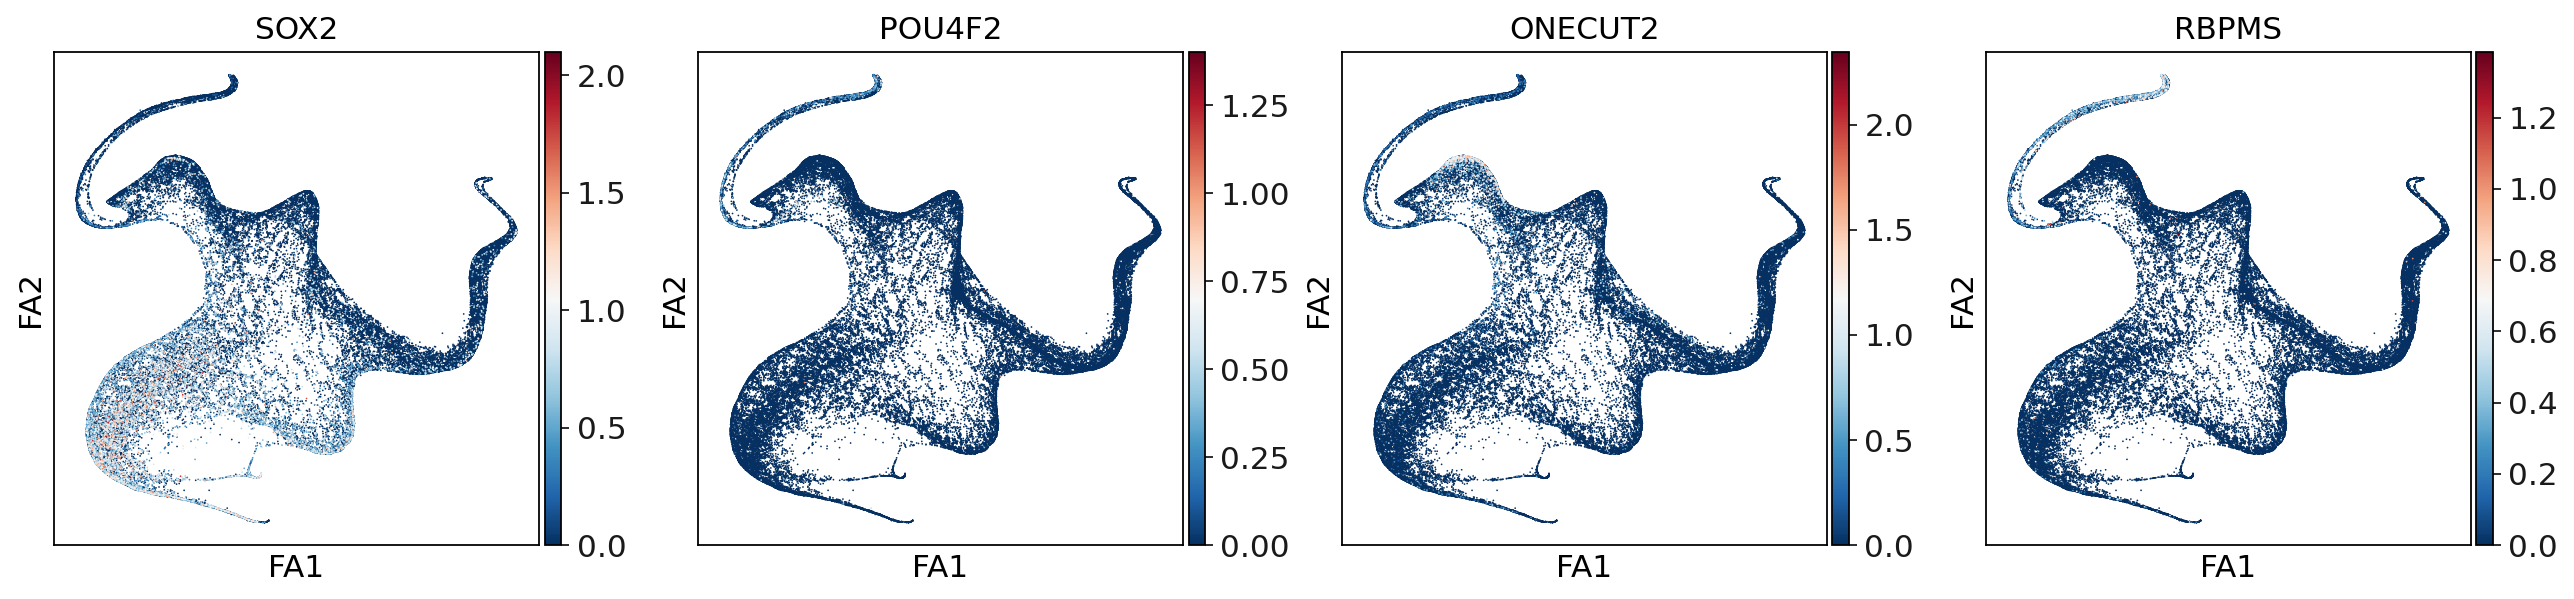

In [98]:
sc.set_figure_params()
sc.pl.draw_graph(adata,color=["SOX2",'POU4F2','ONECUT2','RBPMS'],color_map="RdBu_r")

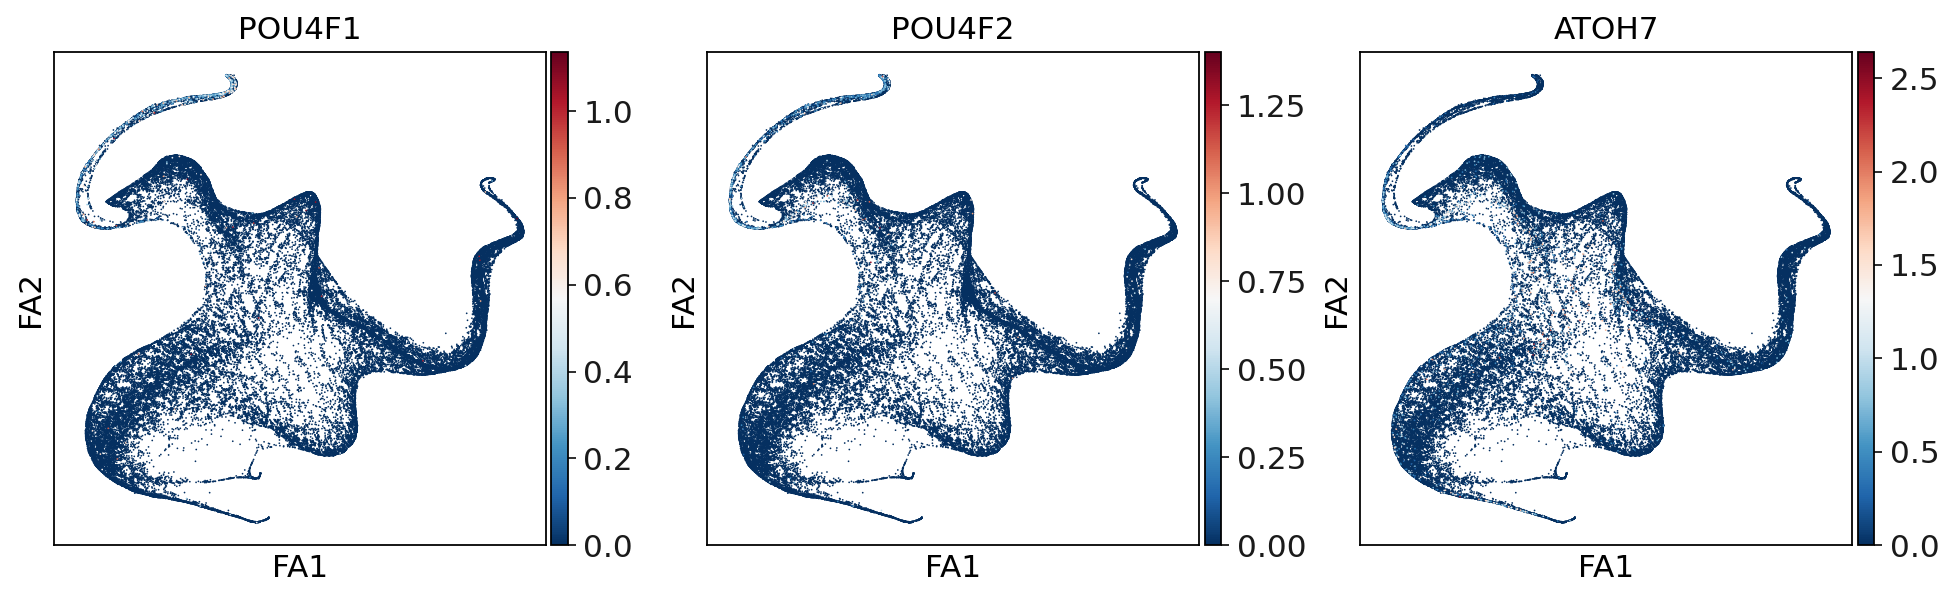

In [46]:
sc.set_figure_params()
sc.pl.draw_graph(adata,color=['POU4F1','POU4F2','ATOH7'],color_map="RdBu_r")

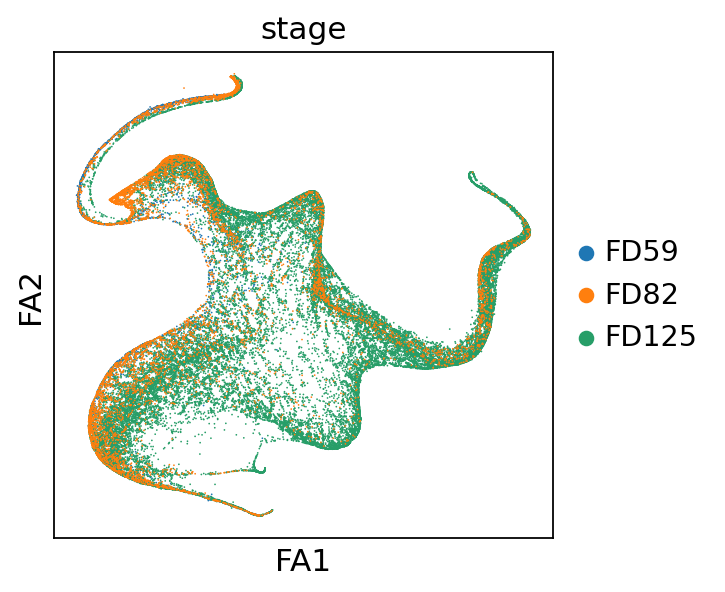

In [134]:
sc.set_figure_params()
sc.pl.draw_graph(adata,color=['stage'],color_map="RdBu_r")

In [126]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 49 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:17)


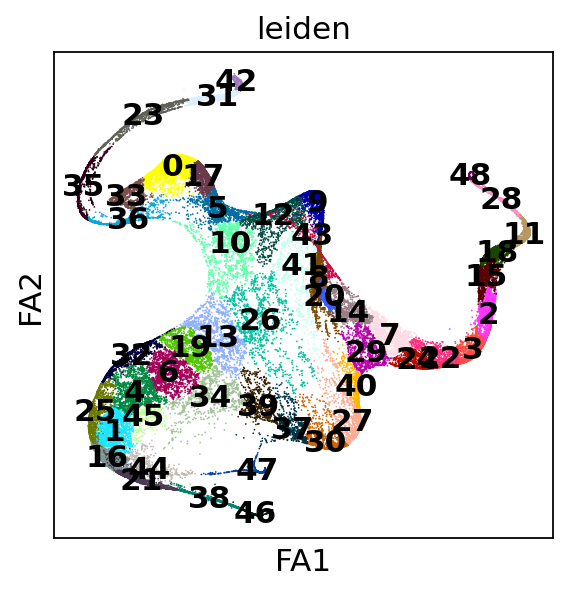

In [127]:
sc.pl.draw_graph(adata,color=["leiden"], legend_loc = 'on data')

In [131]:
adatasubset = adata[adata.obs['leiden'].isin(['42','31','23','35','33','36','0','17','5'])]

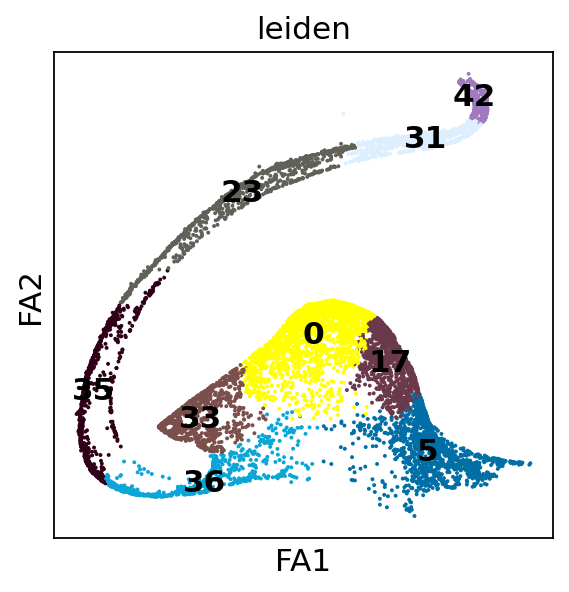

In [132]:
sc.pl.draw_graph(adatasubset,color=["leiden"], legend_loc = 'on data')

In [133]:
adatasubset.var

gene_ids stage-1 stage-2 stage-3 stage-4  n_cells  \
RP11-34P13.3  ENSG00000243485   FD125   FD125    FD82    FD82        1   
RP11-34P13.7  ENSG00000238009   FD125   FD125    FD82    FD82       12   
RP11-34P13.8  ENSG00000239945   FD125   FD125    FD82    FD82        1   
FO538757.2    ENSG00000279457   FD125   FD125    FD82    FD82     1428   
AP006222.2    ENSG00000228463   FD125   FD125    FD82    FD82      880   
...                       ...     ...     ...     ...     ...      ...   
AC007325.4    ENSG00000278817   FD125   FD125    FD82    FD82      191   
AC007325.2    ENSG00000277196   FD125   FD125    FD82    FD82        1   
AL354822.1    ENSG00000278384   FD125   FD125    FD82    FD82       11   
AC004556.1    ENSG00000276345   FD125   FD125    FD82    FD82        4   
AC240274.1    ENSG00000271254   FD125   FD125    FD82    FD82      332   

              highly_variable     means  dispersions  dispersions_norm  
RP11-34P13.3            False  0.000012     0.593960          1.344147  
RP11-34P13.7            False  0.000107     0.621599          0.242403  
RP11-34P13.8             True  0.000017     0.866658          2.807348  
FO538757.2              False  0.013719     0.614714         -1.106546  
AP006222.2              False  0.008033     0.608885         -1.019663  
...                       ...       ...          ...               ...  
AC007325.4              False  0.001455     0.531235         -1.677975  
AC007325.2              False  0.000008     0.411492          0.365092  
AL354822.1              False  0.000111     0.575987         -0.173916  
AC004556.1              False  0.000038     0.571934          0.054530  
AC240274.1              False  0.003123     0.595546         -0.665843  

[24264 rows x 10 columns]

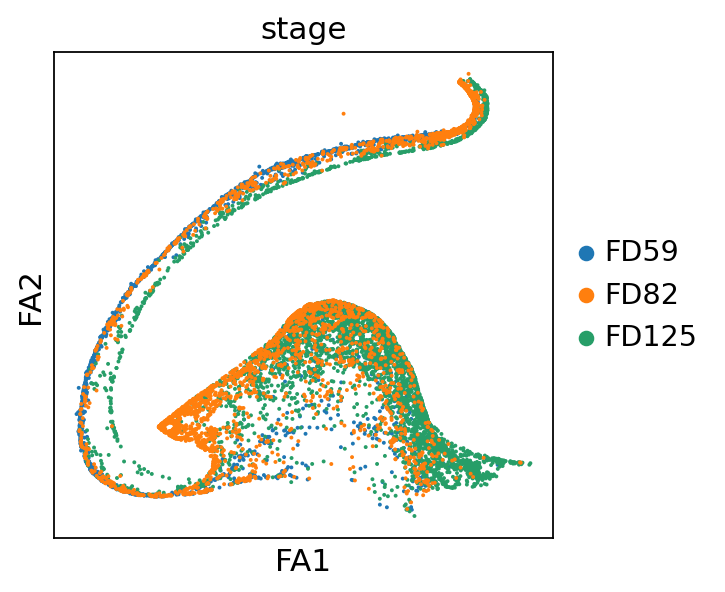

In [135]:
sc.set_figure_params()
sc.pl.draw_graph(adatasubset,color=['stage'],color_map="RdBu_r")

In [136]:
adatasubset_subFD59 = adatasubset[adatasubset.obs['stage'].isin(['FD59']),]

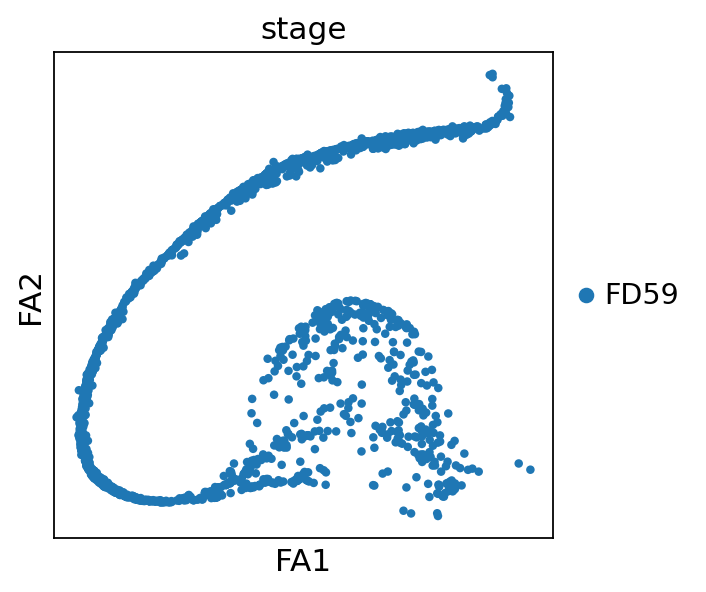

In [137]:
sc.set_figure_params()
sc.pl.draw_graph(adatasubset_subFD59,color=['stage'],color_map="RdBu_r")

In [138]:
adatasubset_subFD82 = adatasubset[adatasubset.obs['stage'].isin(['FD82']),]

In [139]:
adatasubset_subFD125 = adatasubset[adatasubset.obs['stage'].isin(['FD125']),]

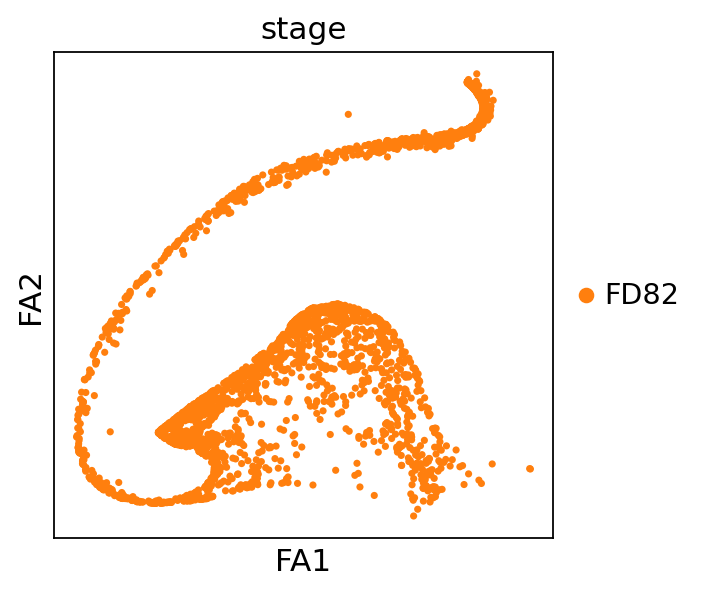

In [147]:
sc.set_figure_params()
sc.pl.draw_graph(adatasubset_subFD82,color=['stage'])

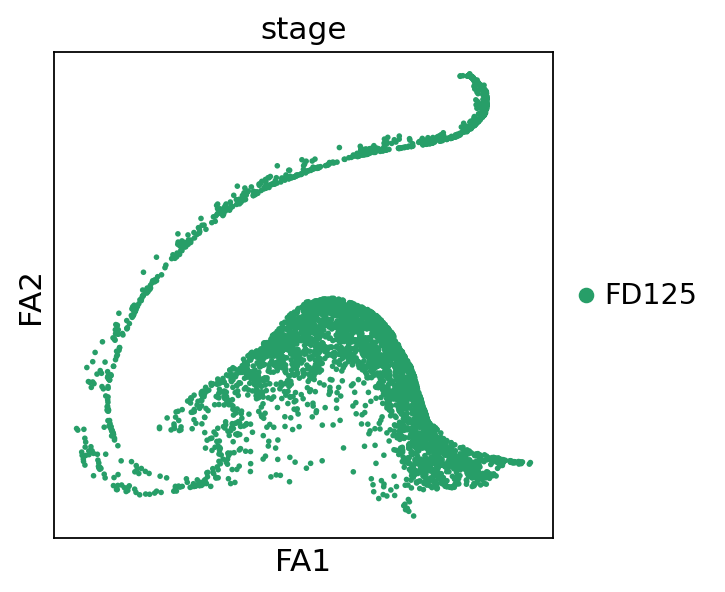

In [148]:
sc.set_figure_params()
sc.pl.draw_graph(adatasubset_subFD125,color=['stage'])

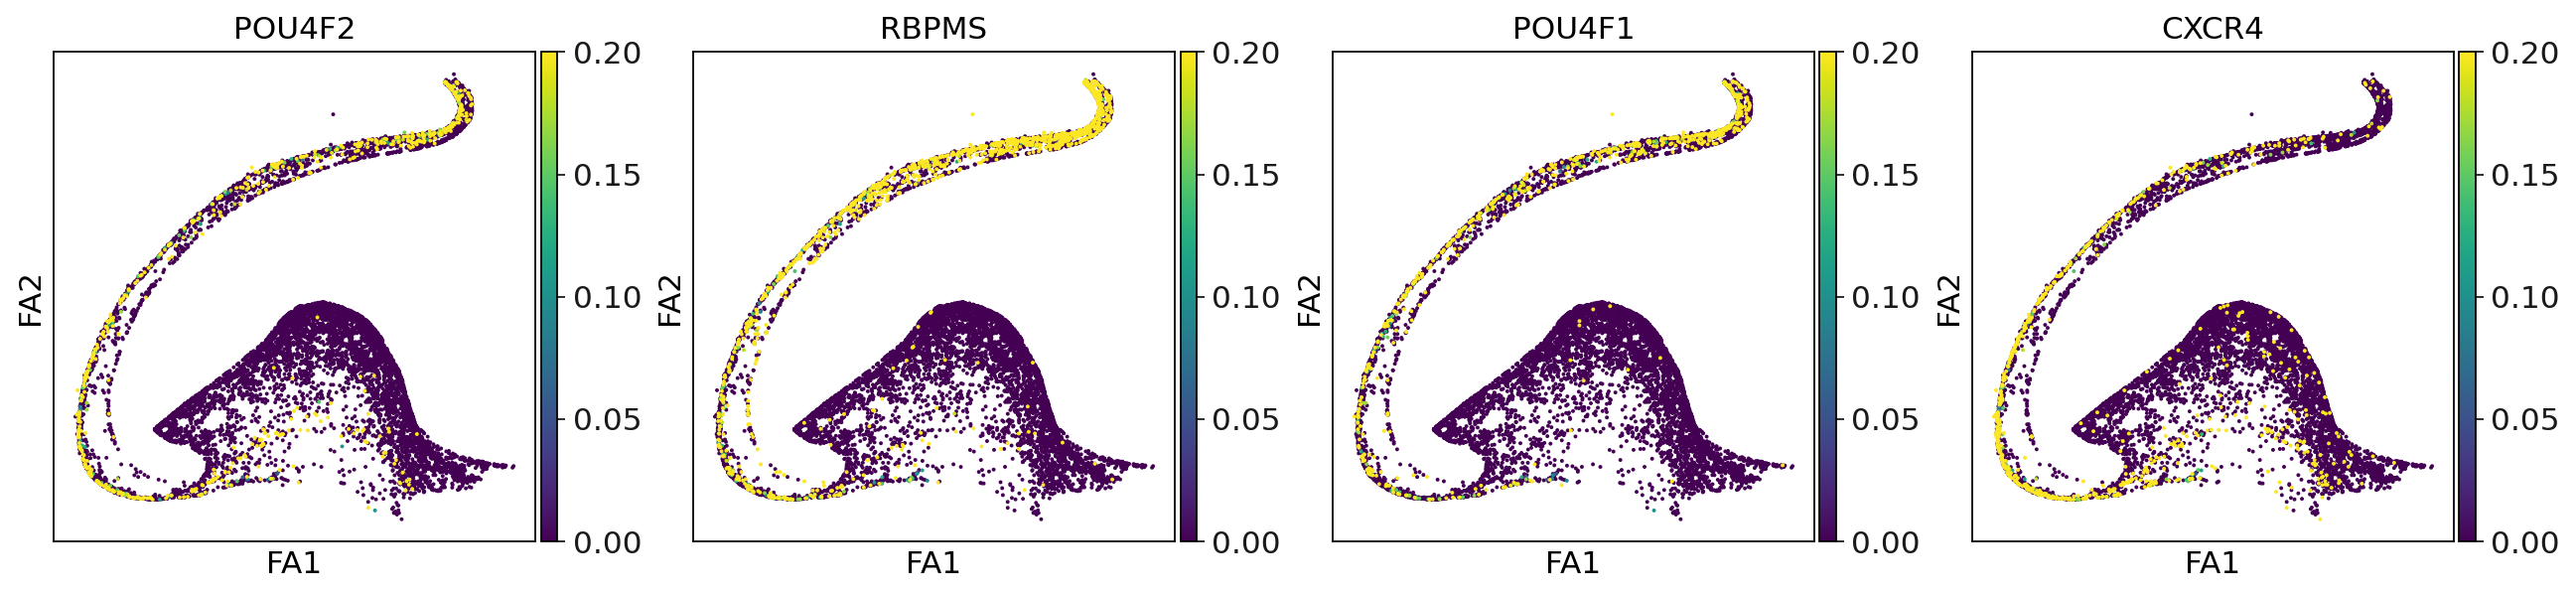

In [154]:
sc.set_figure_params()
sc.pl.draw_graph(adatasubset,color=['POU4F2','RBPMS','POU4F1','CXCR4'], vmax = 0.2)

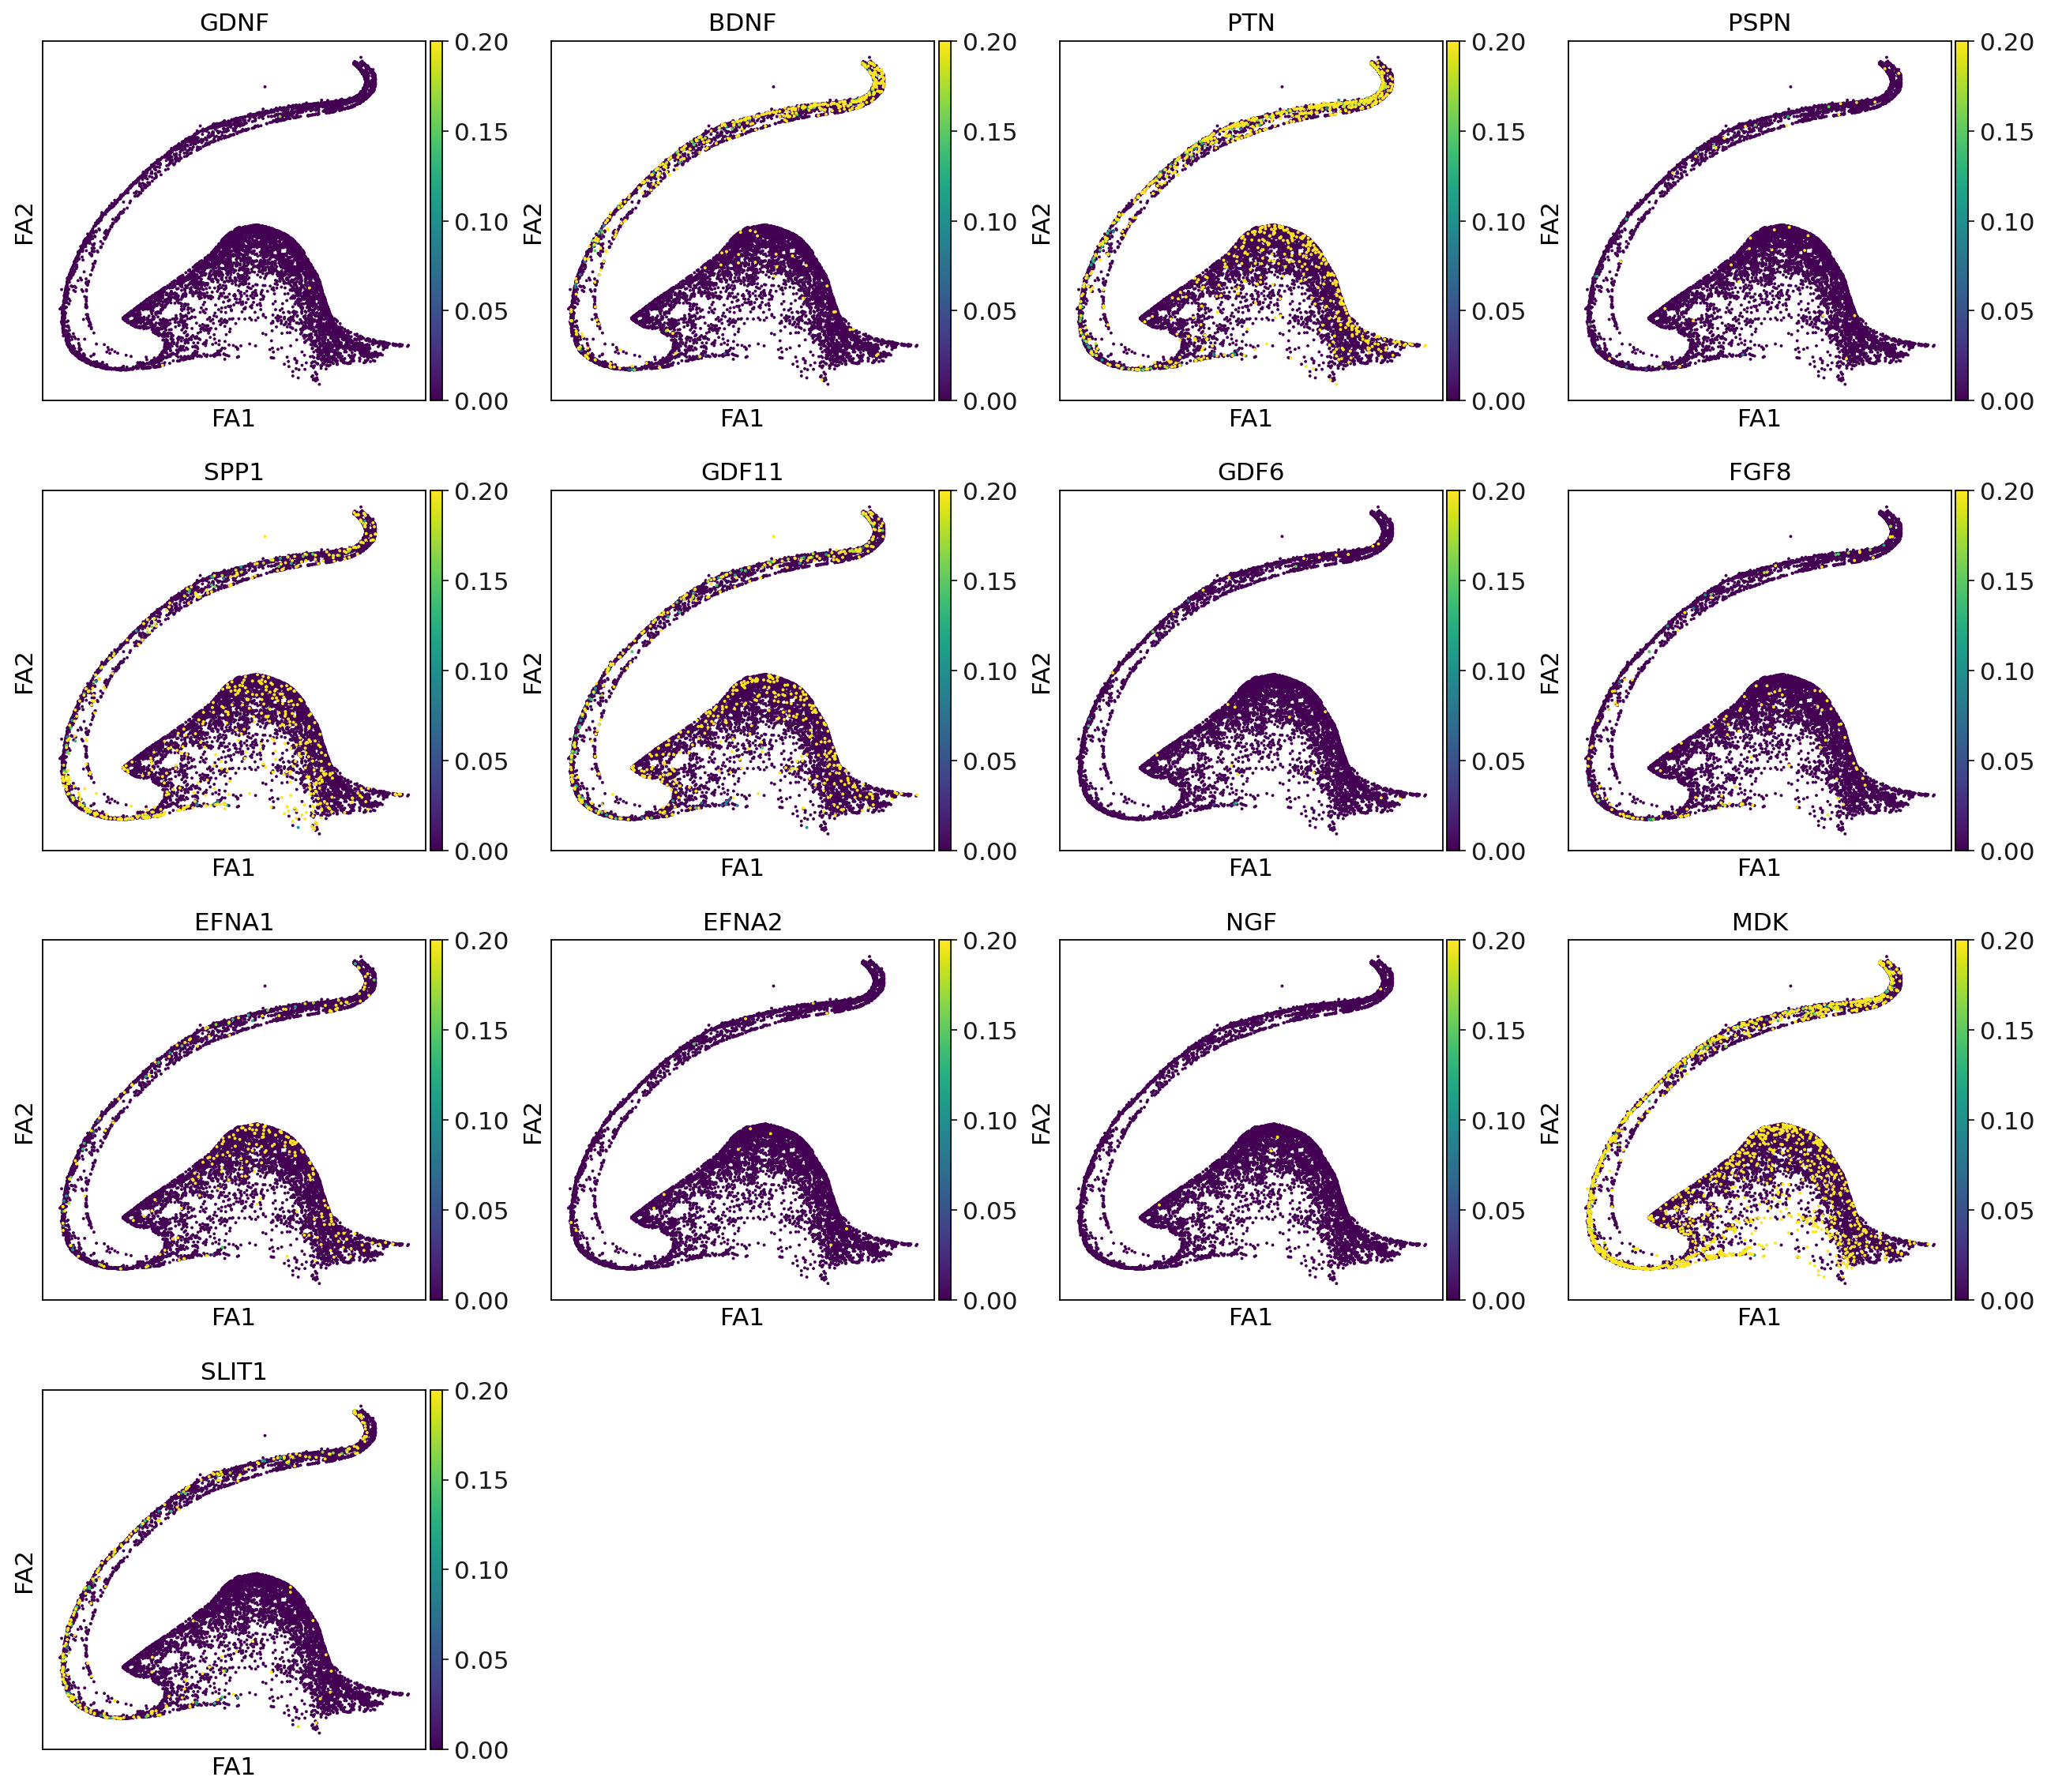

In [153]:
sc.set_figure_params()
sc.pl.draw_graph(adatasubset,color=['GDNF','BDNF','PTN','PSPN','SPP1','GDF11','GDF6','FGF8','EFNA1','EFNA2','NGF','MDK','SLIT1'], vmax = 0.2)

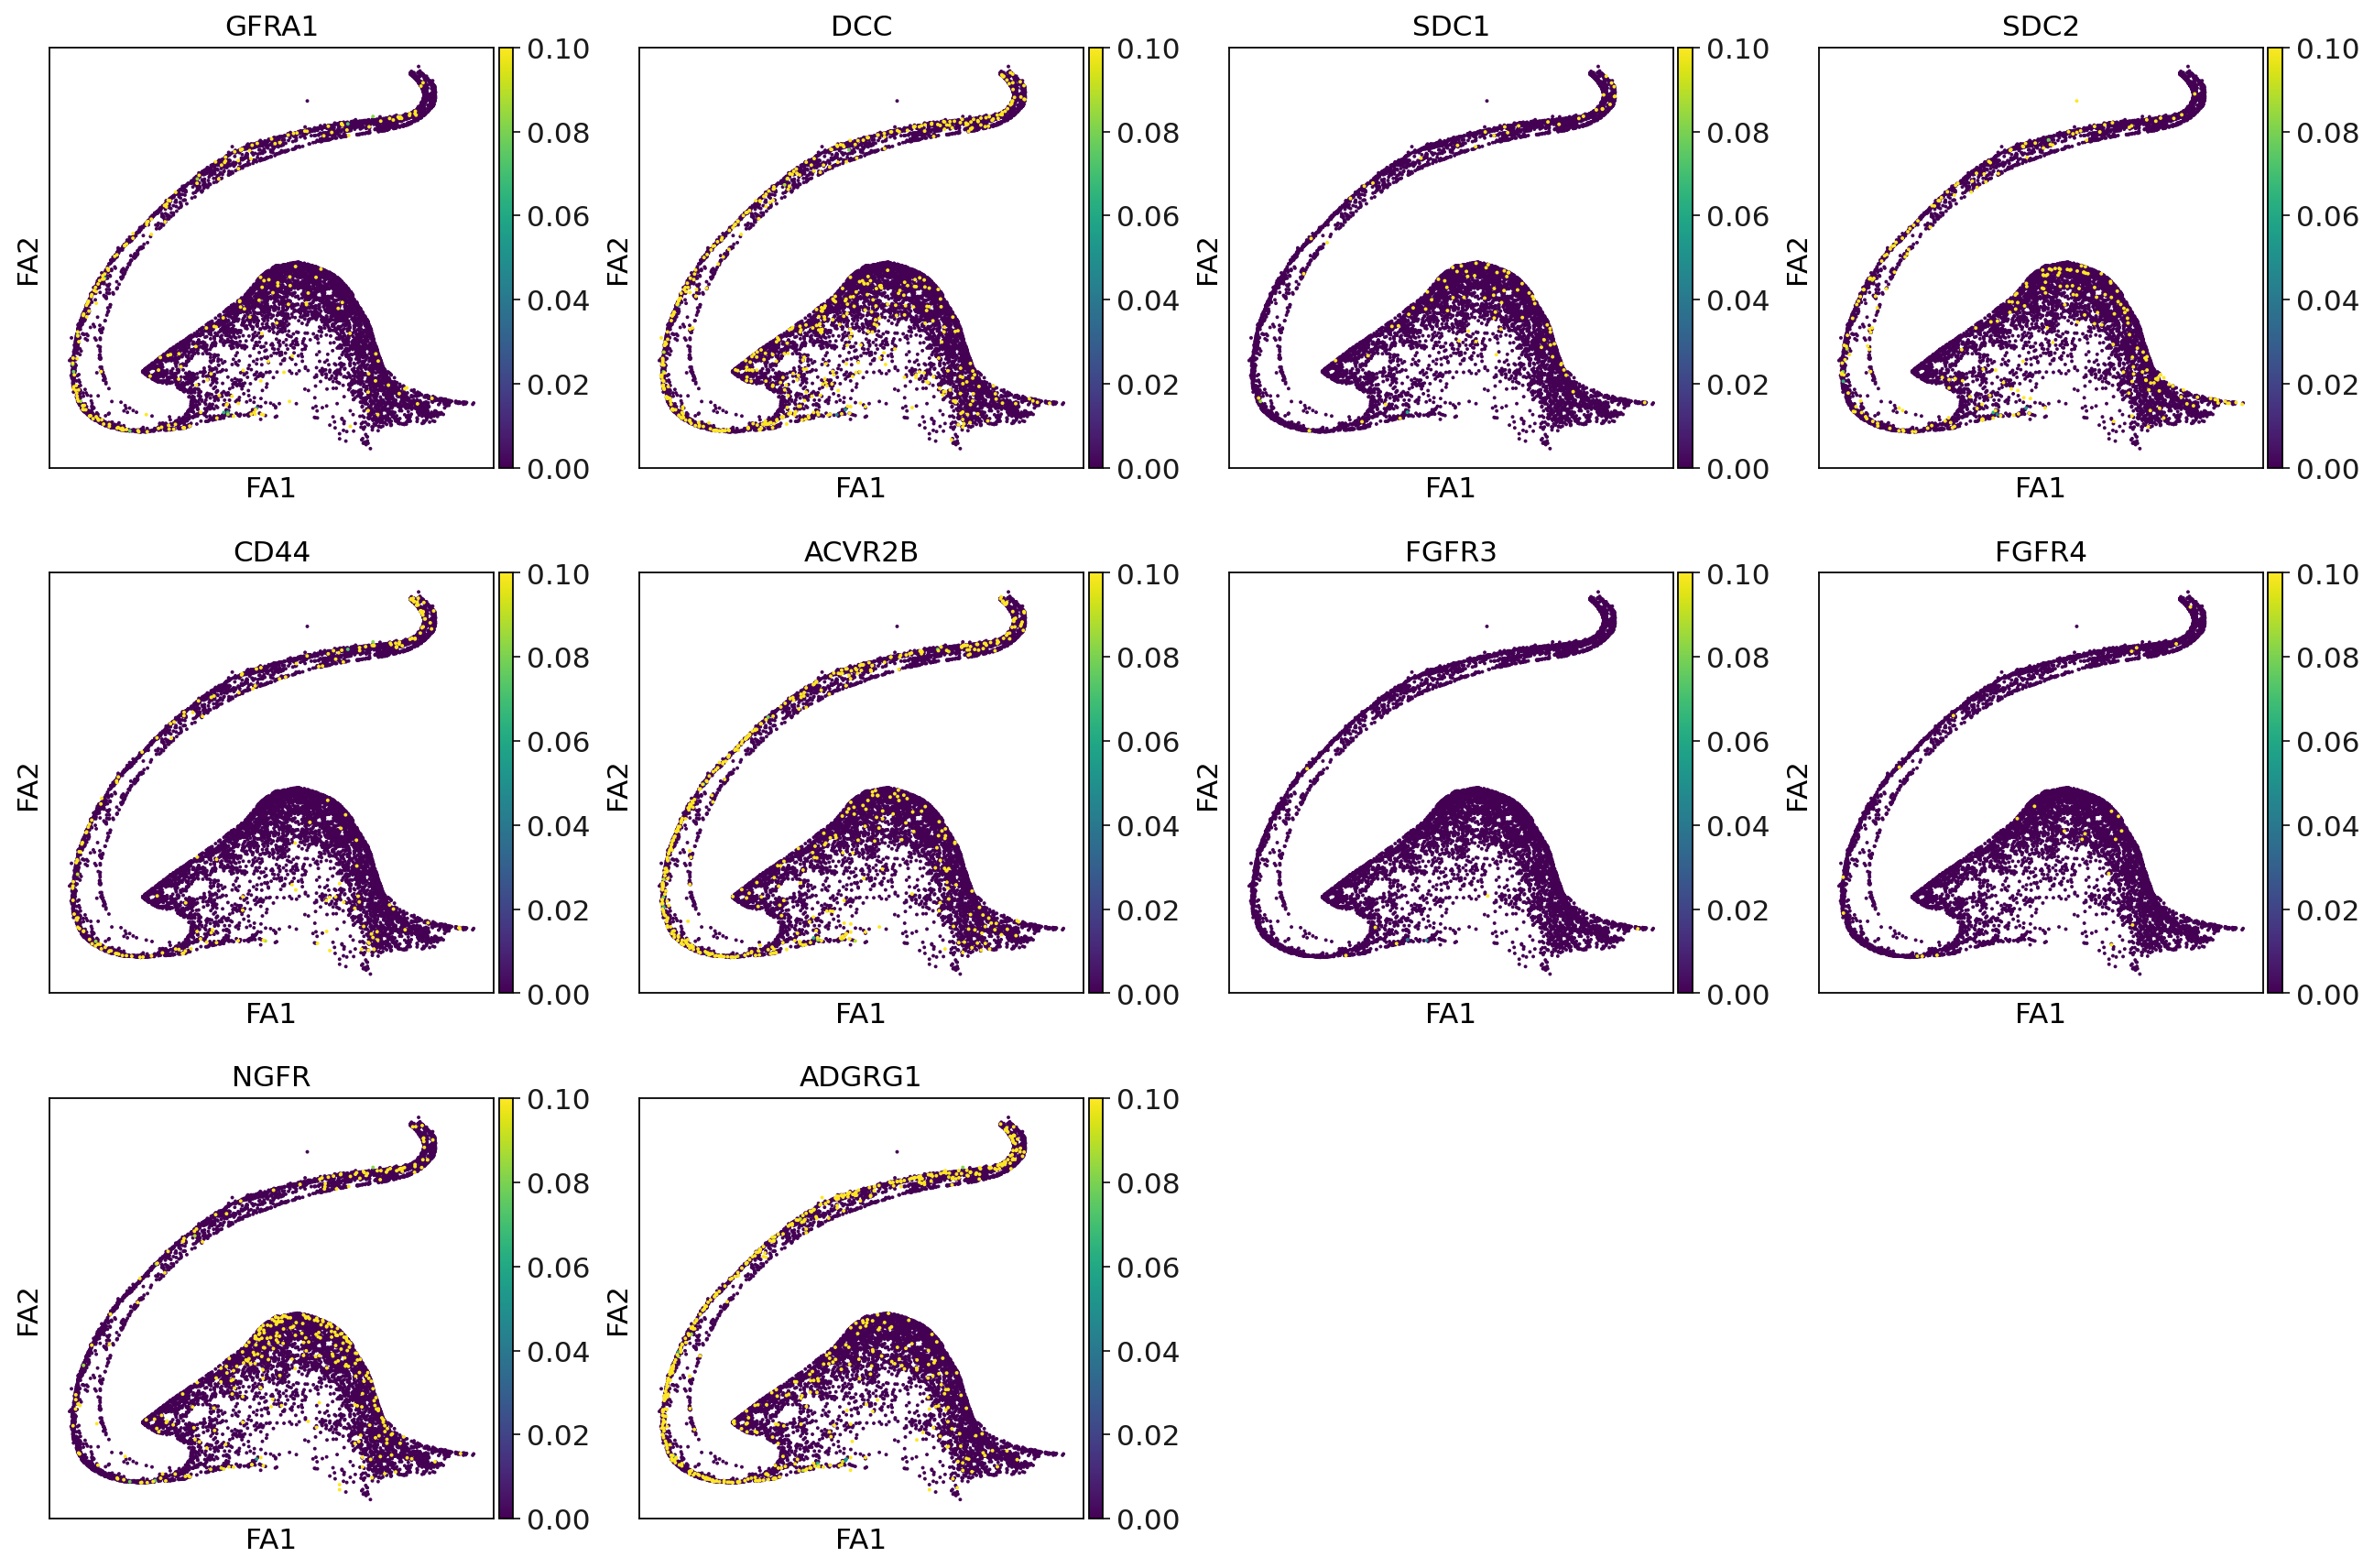

In [157]:
sc.set_figure_params()
sc.pl.draw_graph(adatasubset,color=['GFRA1','DCC','SDC1','SDC2','CD44','ACVR2B','FGFR3','FGFR4','NGFR','ADGRG1'], vmax = 0.1)

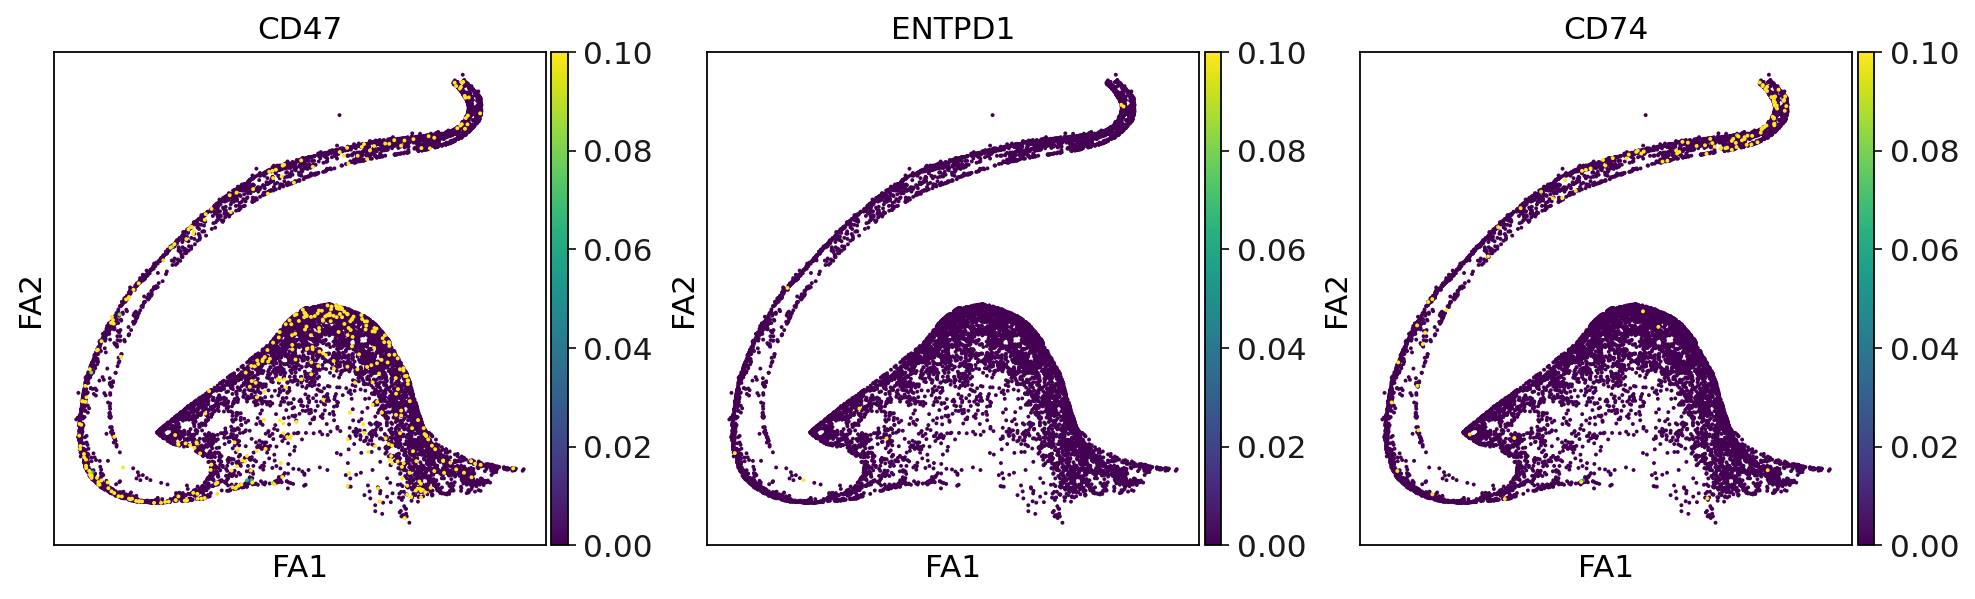

In [159]:
sc.set_figure_params()
sc.pl.draw_graph(adatasubset,color=['CD47','ENTPD1','CD74'], vmax = 0.1)

In [128]:
from platform import python_version

print(python_version())

3.7.0


In [129]:
pip show scFates

Name: scFates
Version: 0.9.0
Summary: scanpy compatible python suite for fast tree inference and advanced pseudotime downstream analysis
Home-page: https://github.com/LouisFaure/scFates
Author: Louis Faure
Author-email: 
License: UNKNOWN
Location: /home/mcrewcow/anaconda3/lib/python3.7/site-packages
Requires: matplotlib, scikit-misc, elpigraph-python, igraph, scikit-learn, networkx, cycler, scanpy, joblib, numpy, anndata, adjustText, python-igraph, tqdm, typing-extensions, plotly, statsmodels, pandas, leidenalg, seaborn, simpleppt, scipy, numba
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [130]:
pip show scanpy

Name: scanpy
Version: 1.9.1
Summary: Single-Cell Analysis in Python.
Home-page: 
Author: Alex Wolf, Philipp Angerer, Fidel Ramirez, Isaac Virshup, Sergei Rybakov, Gokcen Eraslan, Tom White, Malte Luecken, Davide Cittaro, Tobias Callies, Marius Lange, Andrés R. Muñoz-Rojas
Author-email: 
License: 
Location: /home/mcrewcow/anaconda3/lib/python3.7/site-packages
Requires: statsmodels, matplotlib, seaborn, tqdm, pandas, umap-learn, numba, importlib_metadata, packaging, scipy, joblib, patsy, session-info, natsort, scikit-learn, anndata, numpy, networkx, h5py
Required-by: scvelo, scFates, palantir, cellrank
Note: you may need to restart the kernel to use updated packages.
